In [1]:
import os
os.chdir("../../../../")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = str(3)

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import flax.linen as nn
import optax
import pandas as pd
from functools import partial
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
from datasets.dataset_loader import dataset_load
from utilities import plot, gmm, errors, predict, preprocess
from utilities.recalibration_conformal import *
from models import seq2point
import scipy.stats as st
from mapie.metrics import regression_coverage_score
from sklearn.isotonic import IsotonicRegression
from tueplots import bundles
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_reductions --xla_gpu_autotune_level=2"
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Model Training

In [7]:
train = {
    1: {
        'start_time': "2011-04-28",
        'end_time': "2011-05-15"
    },
    3: {
        'start_time': "2011-04-19",
        'end_time': "2011-05-22"
    }
}
test = {
    2: {
        'start_time': "2011-04-21",
        'end_time': "2011-05-21"
    }
}
appliances = ["Microwave"]

In [8]:
datas = dataset_load(appliances, train, test, 99, split_factor=0.25)
x_train, y_train = datas[0], datas[1]
x_cal, y_cal = datas[2], datas[3]
x_test, y_test = datas[4], datas[5]
x_test_timestamp = datas[6]
scaler_x, scaler_y = datas[7], datas[8]

In [9]:
training_predictions_df = pd.DataFrame()
testing_predictions_df = pd.DataFrame()
calibration_predictions_df = pd.DataFrame()
training_predictions_df["Ground Truth"] = scaler_y.inverse_transform(y_train)[
    :, 0]
calibration_predictions_df['Ground Truth'] = scaler_y.inverse_transform(y_cal)[
    :, 0]
testing_predictions_df["Timestamp"] = x_test_timestamp
testing_predictions_df["Ground Truth"] = y_test

In [10]:
model = seq2point.seq2point()

In [11]:
%%capture cap --no-stderr
%%time
params =  model.init(jax.random.PRNGKey(0), x_train, True)
params, losses = fit(model, params, x_train, y_train, False, batch_size=32, learning_rate=0.001, epochs=50)

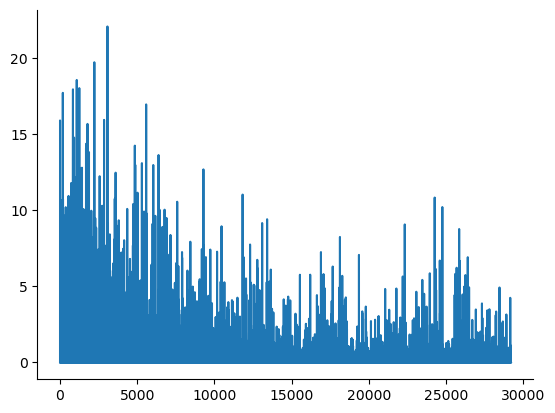

In [12]:
plt.plot(losses)
sns.despine()

In [13]:
mlp_training_time = cap.stdout.split('\n')[1]
mlp_training_time

'Wall time: 41.1 s'

In [14]:
def de_train(x, y, i, model):
    param = model.init(jax.random.PRNGKey(i), x_train, True)
    param, losses = fit(model, param, x, y, False, batch_size=32,
                        learning_rate=0.001, epochs=50)
    return param, losses


de_train = jax.tree_util.Partial(de_train, model=model)


def predict(x, param, model):
    yhat = model.apply(param, x, True)
    return yhat


test_ = jax.tree_util.Partial(predict, model=model)

In [15]:
%%capture cap
%%time
params_list, losses_list = jax.jit(jax.vmap(de_train, in_axes=(None, None, 0)))(x_train, y_train, jnp.arange(10))

In [16]:
de_training_time = cap.stdout.split('\n')[1]
de_training_time

'Wall time: 2min 40s'

# Before Calibration

##### Results on Calibration Set

In [17]:
%%capture cap
%%time
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None, 0)))(x_cal, params_list)

In [18]:
mlp_calibration_time = cap.stdout.split('\n')[1]
mlp_calibration_time

'Wall time: 1.58 s'

In [19]:
de_cal_mean = y_stacks.mean(axis=0)
de_cal_sigma = y_stacks.std(axis=0)

In [20]:
de_cal_mean = scaler_y.inverse_transform(de_cal_mean)
de_cal_sigma = (scaler_y.scale_*de_cal_sigma)
y_true_cal = scaler_y.inverse_transform(y_cal)

In [21]:
print(f"RMSE : {errors.rmse(y_true_cal, de_cal_mean):.4f}",
      f"MAE  : {errors.mae(y_true_cal, de_cal_mean):.4f}",
      f"NLL  : {errors.NLL(de_cal_mean, de_cal_sigma, y_true_cal):.4f}")

RMSE : 68.7141 MAE  : 7.1380 NLL  : 4.8175


##### Results on Training Set

In [22]:
y_stacks_train = jax.jit(
    jax.vmap(test_, in_axes=(None, 0)))(x_train, params_list)
de_train_mean = y_stacks_train.mean(axis=0)
de_train_sigma = y_stacks_train.std(axis=0)

In [23]:
de_train_mean = scaler_y.inverse_transform(de_train_mean)
de_train_sigma = (scaler_y.scale_*de_train_sigma)
y_train_scaled = scaler_y.inverse_transform(y_train)

In [24]:
print(f"RMSE : {errors.rmse(y_train_scaled, de_train_mean):.4f}",
      f"MAE  : {errors.mae(y_train_scaled, de_train_mean):.4f}",
      f"NLL  : {errors.NLL(de_train_mean, de_train_sigma, y_train_scaled):.4f}")

RMSE : 11.7194 MAE  : 2.1496 NLL  : 4.6232


##### Results on Test Set

In [25]:
%%capture cap
%%time
y_stacks_test = jax.jit(
    jax.vmap(test_, in_axes=(None, 0)))(x_test, params_list)

In [26]:
de_test_mean = y_stacks_test.mean(axis=0)
de_test_sigma = y_stacks_test.std(axis=0)

In [27]:
de_test_mean = scaler_y.inverse_transform(de_test_mean)
de_test_sigma = (scaler_y.scale_*de_test_sigma)

In [28]:
print(f"RMSE : {errors.rmse(y_test, de_test_mean):.4f}", f"MAE  : {errors.mae(y_test, de_test_mean):.4f}",
      f"NLL  : {errors.NLL(de_test_mean, de_test_sigma, y_test):.4f}")

RMSE : 79.9578 MAE  : 11.3084 NLL  : 710.8983


In [29]:
mlp_testing_time = cap.stdout.split('\n')[1]
mlp_testing_time

'Wall time: 3.42 s'

# After Calibration

### Isotonic Regression

In [30]:
def ace(ideal, predicted):
    """
    dataframe : pandas dataframe with Ideal and Counts as column for regression calibration
    It can be directly used as 2nd output from calibration_regression in plot.py 
    """
    def rmse_loss(y, yhat):
        return jnp.abs(y-yhat)
    return jnp.mean(jax.vmap(rmse_loss, in_axes=(0, 0))(ideal, predicted))

In [31]:
%%capture cap
%%time
series_train = find_p_hat(y_train_scaled, de_train_mean, de_train_sigma)
series_test = find_p_hat(y_test, de_test_mean, de_test_sigma)
series_cal = find_p_hat(y_true_cal, de_cal_mean, de_cal_sigma)

In [32]:
isotonic_1 = cap.stdout.split('\n')[1]
isotonic_1

'Wall time: 1.14 s'

In [33]:
%%capture cap
%%time
calibrator = IsotonicRegression(out_of_bounds='clip')
calibrator.fit(series_cal.values, series_cal.index)

In [34]:
isotonic_2 = cap.stdout.split('\n')[1]
isotonic_2

'Wall time: 1.92 ms'

In [35]:
%%capture cap
%%time
p = series_cal.index
new_p = calibrator.predict(series_cal.index)

In [36]:
isotonic_3 = cap.stdout.split('\n')[1]
isotonic_3

'Wall time: 320 us'

In [37]:
%%capture cap
%%time
new_p_hat_train = find_new_p_hat(
    y_train_scaled, new_p, de_train_mean, de_train_sigma)
new_p_hat_cal = find_new_p_hat(y_true_cal, new_p, de_cal_mean, de_cal_sigma)
new_p_hat_test = find_new_p_hat(y_test, new_p, de_test_mean, de_test_sigma)

In [38]:
isotonic_4 = cap.stdout.split('\n')[1]
isotonic_4

'Wall time: 45.7 ms'

In [39]:
mlp_training_time

'Wall time: 41.1 s'

In [40]:
train_time = float(mlp_training_time[11:14]) + int(
    de_training_time[11:12])*60 + int(de_training_time[16:-1])
calibration_time = float(mlp_calibration_time[11:15])
isotonic_time_final = float(
    isotonic_1[11:15]) + float(isotonic_2[11:15])/1000
+ float(isotonic_3[11:14])/1000000 + float(isotonic_4[11:14])/1000

0.04532

In [41]:
total_time = train_time + calibration_time + isotonic_time_final
total_time

203.72192

In [42]:
with open('notebooks/microwave/s2p/mlp/time_homo_de.txt', 'w') as file:
    file.writelines([f"MLP training :{mlp_training_time} ", f" MLP Calibration: {mlp_calibration_time}\n"
                     f"Isotonic Time: {isotonic_time_final} ", f"Total time: {total_time}s"])

In [43]:
add = []
extra = [train_time, calibration_time, isotonic_time_final, total_time]
add.append(extra)
add

[[201.0, 1.58, 1.1419199999999998, 203.72192]]

In [44]:
time = pd.DataFrame(add)

In [45]:
time.to_csv('notebooks/microwave/s2p/mlp/homo_de.csv',
            mode='a', index=False)

In [46]:
bundles.icml2022()

{'text.usetex': True,
 'font.family': 'serif',
 'text.latex.preamble': '\\usepackage{times} ',
 'figure.figsize': (3.25, 2.0086104634371584),
 'figure.constrained_layout.use': True,
 'figure.autolayout': False,
 'savefig.bbox': 'tight',
 'savefig.pad_inches': 0.015,
 'font.size': 8,
 'axes.labelsize': 8,
 'legend.fontsize': 6,
 'xtick.labelsize': 6,
 'ytick.labelsize': 6,
 'axes.titlesize': 8}

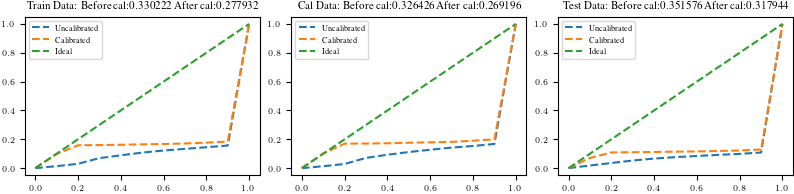

In [47]:
plt.rcParams.update(bundles.icml2022())
plt.rcParams.update({'figure.figsize': (8, 2)})
plt.subplot(1, 3, 1)
plt.plot(p, series_train.values, label='Uncalibrated', linestyle='--')
plt.plot(p, new_p_hat_train, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f"Train Data: Before cal:{ace(p.values,series_train.values):2f} After cal:{ace(p.values,new_p_hat_train):2f}")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(p, series_cal.values, label='Uncalibrated', linestyle='--')
plt.plot(p, new_p_hat_cal, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f"Cal Data: Before cal:{ace(p.values,series_cal.values):2f} After cal:{ace(p.values,new_p_hat_cal):2f}")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(p, series_test.values, label='Uncalibrated', linestyle='--')
plt.plot(p, new_p_hat_test, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f"Test Data: Before cal:{ace(p.values,series_test.values):2f} After cal:{ace(p.values,new_p_hat_test):2f}")
plt.legend()
plt.savefig(
    f'/home/haikoo.khandor/haikoo/conformal/con_figures/{appliances[0]}_S2P_Homo_DE.pdf')